In [1]:
import tweepy
import yaml
import json
import networkx as nx
import sqlite3

# for the louvain package
import community as community_louvain
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
# yaml file reader funtion
def read_yaml(file_path):
    with open(file_path, "r") as f:
        return yaml.safe_load(f)

# yaml config file path
file_path = "twitter_api_key_config.yaml"
# read from config file
api_credential = read_yaml(file_path)

# API authentication
auth = tweepy.OAuthHandler(api_credential["api_key"], \
                           api_credential["api_secret_token"])
auth.set_access_token(api_credential["access_token"], \
                      api_credential["access_token_secret"])
api = tweepy.API(auth, wait_on_rate_limit=True)

In [2]:
conn = sqlite3.connect('project_data.db')
cursor = conn.cursor()

# users.ignoring is for locked & non-verified accounts
cursor.execute("""
CREATE TABLE IF NOT EXISTS users (
    id BIGINT PRIMARY KEY,
    screen_name TEXT,
    ignoring INTEGER DEFAULT 0
)
""")
cursor.execute("""
CREATE TABLE IF NOT EXISTS interactions (
    source BIGINT,
    target BIGINT,
    type TEXT,
    count INTEGER DEFAULT 1,
    PRIMARY KEY (source, target, type)
)
""")
conn.commit()

In [4]:
USERS_GOAL = 10_000

def gather_data():
    # helper methods
    def count_users():
        cursor.execute("""
            SELECT COUNT(*)
            FROM users
            WHERE ignoring = FALSE
        """)
        result, = cursor.fetchone()
        return result

    def most_popular_pending_user():
        cursor.execute("""
            SELECT target
            FROM interactions
            WHERE target NOT IN (SELECT id FROM users)
            GROUP BY target
            ORDER BY SUM(count) DESC
            LIMIT 1
        """)
        row = cursor.fetchone()
        if row is None:
            return None
        result, = row
        return result

    def record_interaction(source, target, interaction_type):
        params = {"source": source, "target": target, "type": interaction_type}
        cursor.execute(
            """
            INSERT INTO interactions (source, target, type)
            VALUES (:source, :target, :type)
            ON CONFLICT(source, target, type) DO UPDATE SET count = count + 1
            """,
            params
        )

    # accepts kwargs so either `user_id` or `screen_name` can be provided
    def get_user_connections(**kwargs):
        user_data = api.get_user(**kwargs)
        user_id = user_data.id
        user_screen_name = user_data.screen_name

        protected_account = user_data.protected
        verified_account = user_data.verified
        ignoring = protected_account or not verified_account

        cursor.execute(
            """
            INSERT INTO users (id, screen_name, ignoring)
            VALUES (:id, :screen_name, :ignoring)
            """,
            {"id": user_id, "screen_name": user_screen_name, "ignoring": ignoring}
        )

        if ignoring:
            return

        print('Gathering all data for @' + user_screen_name)

        for following_id in tweepy.Cursor(api.get_friend_ids, user_id=user_id).items():
            record_interaction(user_id, following_id, 'follow')

        timeline = tweepy.Cursor(api.user_timeline, user_id=user_id,
                                 exclude_replies=False, include_rts=True)
        for tweet in timeline.items():
            retweeted_status = getattr(tweet, 'retweeted_status', None)
            if retweeted_status is not None:
                retweeted_user = retweeted_status.user
                record_interaction(user_id, retweeted_user.id, 'retweet')
            if tweet.in_reply_to_user_id is not None:
                record_interaction(user_id, tweet.in_reply_to_user_id, 'reply')

    if count_users() == 0:
        get_user_connections(screen_name='xychelsea')

    while count_users() < USERS_GOAL:
        next_user_id = most_popular_pending_user()
        if next_user_id is None:
            print('ran out of pending users')
            break
        get_user_connections(user_id=next_user_id)
        conn.commit()
    print('now have', count_users(), 'users')

In [5]:
# just for testing
USERS_GOAL = 5
gather_data()

Gathering all data for @xychelsea
Gathering all data for @hasanthehun


Rate limit reached. Sleeping for: 75


Gathering all data for @janusrose
Gathering all data for @JordanUhl
Gathering all data for @kenklippenstein
now have 5 users


In [3]:
# creates the graph from the database
G_following = nx.Graph()
G_retweet = nx.Graph()
G_reply = nx.Graph()

#grabbing all users and adding them to the graphs
users_sc = [sc[0] for sc in cursor.execute("""SELECT id FROM users WHERE ignoring = FALSE""")]
print(len(users_sc))
G_following.add_nodes_from(users_sc)
G_retweet.add_nodes_from(users_sc)
G_reply.add_nodes_from(users_sc)

cursor.execute("""SELECT source, target, type, count FROM interactions""")
interactions = cursor.fetchall()
for i in interactions:
    if i[2] == 'follow':
        G_following.add_edge(i[0], i[1], weight=i[3])
    elif i[2] == 'retweet':
        G_retweet.add_edge(i[0], i[1], weight=i[3])
    elif i[2] == 'reply':
        G_reply.add_edge(i[0], i[1], weight=i[3])

2069


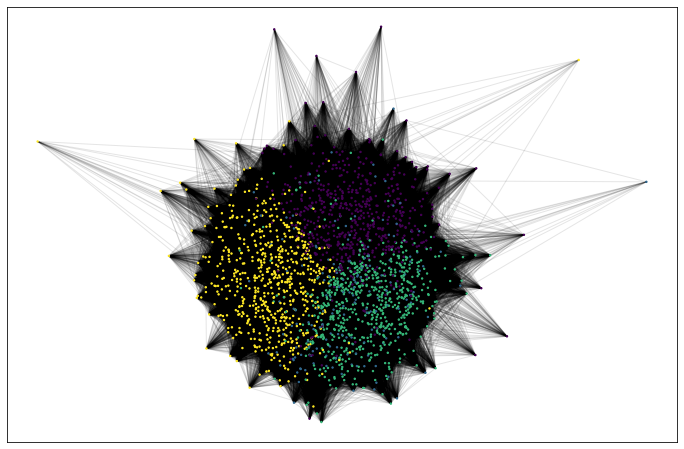

In [12]:
plt.figure(figsize=(12,8))

partition_following = community_louvain.best_partition(G_following)
posf = nx.spring_layout(G_following)
cmapf = cm.get_cmap('viridis', max(partition_following.values()) + 1)
nx.draw_networkx_nodes(G_following, posf, partition_following.keys(),
                      node_size=2,cmap=cmapf, node_color=list(partition_following.values()))
nx.draw_networkx_edges(G_following, posf, alpha=0.1)
#plt.show()
plt.savefig('following_w_edge.png')

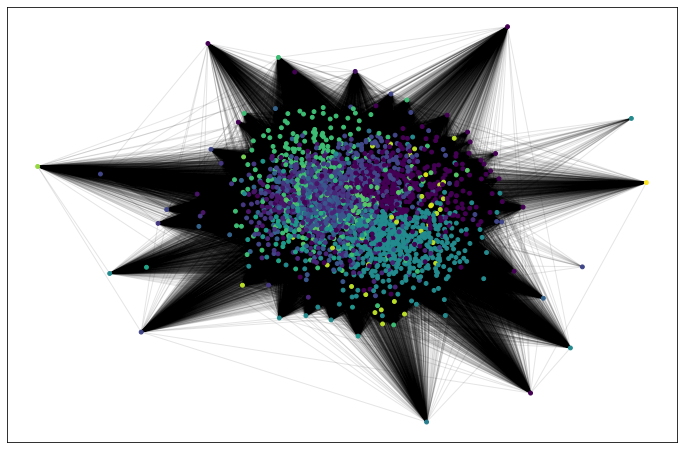

In [9]:
plt.figure(figsize=(12,8))

partition_retweet = community_louvain.best_partition(G_retweet)
posrt = nx.spring_layout(G_retweet, k=0.4)
cmaprt = cm.get_cmap('viridis', max(partition_retweet.values()) + 1)
nx.draw_networkx_nodes(G_following, posrt, partition_retweet.keys(),
                      node_size=15,cmap=cmaprt, node_color=list(partition_retweet.values()))
nx.draw_networkx_edges(G_following, posrt, alpha=0.1)
plt.savefig('retweet_w_edge.png')

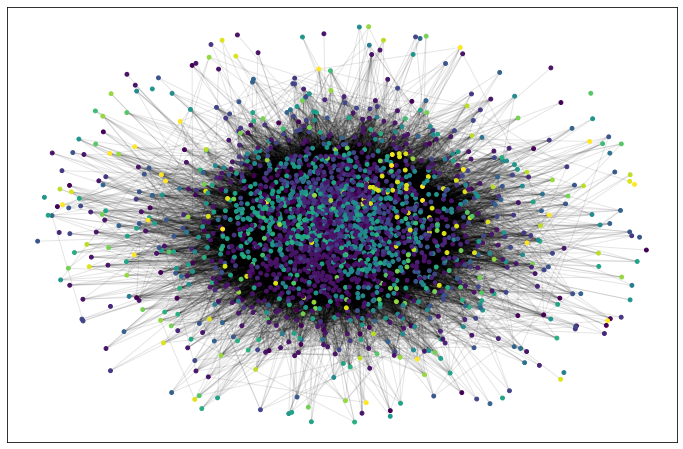

In [10]:
plt.figure(figsize=(12,8))

partition_reply = community_louvain.best_partition(G_reply)
posrp = nx.spring_layout(G_reply, k=0.4)
cmaprp = cm.get_cmap('viridis', max(partition_retweet.values()) + 1)
nx.draw_networkx_nodes(G_reply, posrp, partition_reply.keys(),
                      node_size=15,cmap=cmaprp, node_color=list(partition_reply.values()))
nx.draw_networkx_edges(G_reply, posrp, alpha=0.1)
plt.savefig('reply_w_edge.png')

In [44]:
following_modularity = community_louvain.modularity(partition_following, G_following)
print(f'{following_modularity = }')
retweet_modularity = community_louvain.modularity(partition_retweet, G_retweet)
print(f'{retweet_modularity = }')
reply_modularity = community_louvain.modularity(partition_reply, G_reply)
print(f'{reply_modularity = }')

following_modularity = 0.10577850078381329
retweet_modularity = 0.4202602433197357
reply_modularity = 0.8036589592688087
